<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Load" data-toc-modified-id="Model-Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Load</a></span></li><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Load</a></span></li><li><span><a href="#Graph-func" data-toc-modified-id="Graph-func-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Graph func</a></span></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#CIFAR10" data-toc-modified-id="CIFAR10-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CIFAR10</a></span></li></ul></div>

This notebook will check the results of your assessment of MNIST and CIFAR10 as a pretrained model. So if you don't have a pretrained model, you'll have to run it through the command below and then create a pretrained model first.

```
> python main.py
```

In [10]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset

import numpy as np
import sys
import os 
import json
sys.path.append('../code')

from dataload import mnist_load, cifar10_load
from model import SimpleCNNMNIST, SimpleCNNCIFAR10

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Model Checkpoints')
print(os.listdir('../checkpoint'))
print()
print('Model Logs')
print(os.listdir('../logs'))

Model Checkpoints
['resnet50_cifar10.pth', 'resnet50_mnist.pth', 'simple_cnn_cifar10.pth', 'simple_cnn_mnist.pth']

Model Logs
['resnet50_cifar10_logs.txt', 'resnet50_mnist_logs.txt', 'simple_cnn_cifar10_logs.txt', 'simple_cnn_mnist_logs.txt']


# Model Load

In [11]:
# mnist
mnist_simplecnn = torch.load('../checkpoint/simple_cnn_mnist.pth')
mnist_model = SimpleCNNMNIST()
mnist_model.load_state_dict(mnist_simplecnn['model'])

# cifar10
cifar10_simplecnn = torch.load('../checkpoint/simple_cnn_cifar10.pth')
cifar10_model = SimpleCNNCIFAR10()
cifar10_model.load_state_dict(cifar10_simplecnn['model'])

<All keys matched successfully>

In [12]:
# Logs load
with open('../logs/simple_cnn_mnist_logs.txt','r') as file:
    mnist_simplecnn_logs = json.load(file)
with open('../logs/simple_cnn_cifar10_logs.txt','r') as file:
    cifar10_simplecnn_logs = json.load(file)

# Data Load

**MNIST**

In [13]:
# Transforms
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
# Data Load
mnist_test = dset.MNIST(root='../dataset/MNIST',
                        train=False,
                        transform=mnist_transform,
                        download=True)
mnist_testloader = DataLoader(dataset=mnist_test,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0)
# idx2class
mnist_class2idx = mnist_test.class_to_idx
mnist_idx2class = dict(zip(list(mnist_class2idx.values()), list(mnist_class2idx.keys())))
mnist_idx2class

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

**CIFAR10**

In [14]:
# Transforms
cifar10_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


# Data Load
cifar10_test = dset.CIFAR10(root='../dataset/CIFAR10',
                          train=False,
                          transform=cifar10_transform_test,
                          download=True)
cifar10_testloader = DataLoader(dataset=cifar10_test,
                                batch_size=128,
                                shuffle=False,
                                num_workers=0)
# idx2class
cifar10_class2idx = cifar10_test.class_to_idx
cifar10_idx2class = dict(zip(list(cifar10_class2idx.values()), list(cifar10_class2idx.keys())))
cifar10_idx2class

Files already downloaded and verified


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Graph func

In [15]:
def loss_acc_plot(train, valid, width, height, title):
    plt.figure(figsize=(width, height))
    ax = sns.lineplot(x=np.arange(len(train['acc'])), y=train['acc'], label='Train Acc')
    sns.lineplot(x=np.arange(len(valid['acc'])), y=valid['acc'], label='Valid Acc', ax=ax)
    ax_2 = ax.twinx()
    sns.lineplot(x=np.arange(len(train['loss'])), y=train['loss'], label='Train Loss', ax=ax_2)
    sns.lineplot(x=np.arange(len(valid['loss'])), y=valid['loss'], label='Valid Loss', ax=ax_2)
    plt.title(title, size=15)
    plt.legend()
    plt.show()

In [16]:
def acc_by_class(model, data, true, device):
    # ture type must be numpy array
    indices_by_idx = dict((idx, np.where(true==idx)) for idx in range(10))
    
    # test
    model.to(device)
    model.eval()
    pred_lst = []
    with torch.no_grad():
        for inputs, targets in data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).detach()
            
            _, predicted = outputs.max(1)
            pred_lst.extend(predicted.cpu().numpy())
    
    pred = np.array(pred_lst)
    
    for idx in range(10):
        indices = indices_by_idx[idx]
        true_idx = true[indices]
        pred_idx = pred[indices]
        correct = np.sum(true_idx == pred_idx)
        acc_idx = correct / true_idx.size
        
        print("Class {0:}'s accuracy : {1:.2%}".format(idx, acc_idx))

# MNIST

In [17]:
total_nb_size = sum(torch.numel(e) for _, e in mnist_simplecnn['model'].items())
print('Number of Model Parameters: ', total_nb_size)
print('Best Accuracy: {:.2%}'.format(mnist_simplecnn['best_acc']))
print('Best Epoch: ',mnist_simplecnn['best_epoch'])

Number of Model Parameters:  1284493
Best Accuracy: 99.41%
Best Epoch:  141


In [18]:
acc_by_class(mnist_model, mnist_testloader, np.array(mnist_test.targets), device)

Class 0's accuracy : 99.59%
Class 1's accuracy : 99.56%
Class 2's accuracy : 99.22%
Class 3's accuracy : 99.80%
Class 4's accuracy : 98.98%
Class 5's accuracy : 99.22%
Class 6's accuracy : 98.64%
Class 7's accuracy : 99.32%
Class 8's accuracy : 99.49%
Class 9's accuracy : 99.01%


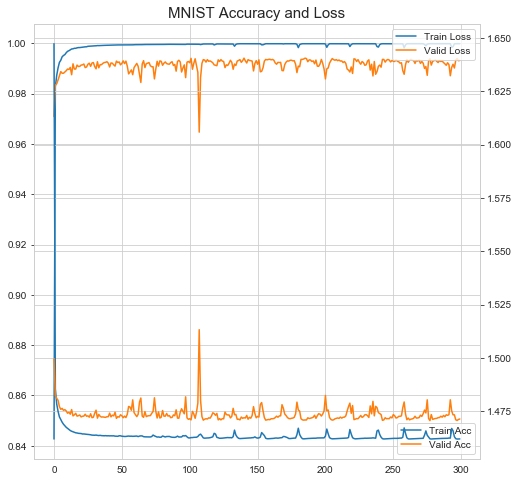

In [19]:
loss_acc_plot(train=mnist_simplecnn_logs['train'][0],
              valid=mnist_simplecnn_logs['validation'][0],
              width=8, height=8,
              title='MNIST Accuracy and Loss')

# CIFAR10

In [20]:
total_nb_size = sum(torch.numel(e) for _, e in cifar10_simplecnn['model'].items())
print('Number of Model Parameters: ', total_nb_size)
print('Best Accuracy: {:.2%}'.format(cifar10_simplecnn['best_acc']))
print('Best Epoch: ',cifar10_simplecnn['best_epoch'])

Number of Model Parameters:  2202573
Best Accuracy: 85.62%
Best Epoch:  271


In [21]:
acc_by_class(cifar10_model, cifar10_testloader, np.array(cifar10_test.targets), device)

Class 0's accuracy : 88.40%
Class 1's accuracy : 93.10%
Class 2's accuracy : 77.30%
Class 3's accuracy : 65.30%
Class 4's accuracy : 87.50%
Class 5's accuracy : 82.80%
Class 6's accuracy : 90.20%
Class 7's accuracy : 85.50%
Class 8's accuracy : 92.00%
Class 9's accuracy : 90.40%


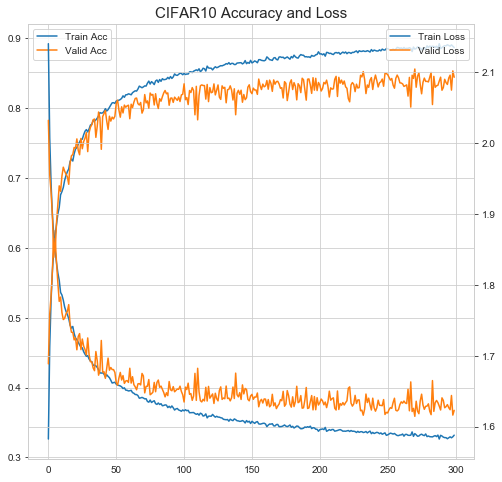

In [22]:
loss_acc_plot(train=cifar10_simplecnn_logs['train'][0],
              valid=cifar10_simplecnn_logs['validation'][0],
              width=8, height=8,
              title='CIFAR10 Accuracy and Loss')